In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
adityajn105_flickr8k_path = kagglehub.dataset_download('adityajn105/flickr8k')

print('Data source import complete.')


Data source import complete.


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/flickr8k


In [6]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pickle

In [ ]:
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input




# Paths
image_dir = "/kaggle/input/flickr8k/Images"
captions_file = "/kaggle/input/flickr8k/captions.txt"

# Load captions
def load_captions(filepath):
    captions = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split(',', 1)
            if len(parts) != 2:
                continue
            img_id, caption = parts
            if img_id not in captions:
                captions[img_id] = []
            captions[img_id].append(f"startseq {caption.strip()} endseq")
    if not captions:
        raise ValueError("No captions were loaded. Check the captions file format.")
    return captions

captions_dict = load_captions(captions_file)
print(f"Total images with captions: {len(captions_dict)}")

# EfficientNetb2 feature extractor

base_model = EfficientNetB0(include_top=False, weights="/kaggle/input/efficientnetb0-notop-h5/efficientnetb0_notop.h5", input_shape=(299, 299, 3))
x = GlobalAveragePooling2D()(base_model.output)
model = Model(inputs=base_model.input, outputs=x)
model.trainable = False

# Preprocess image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return preprocess_input(img)

# Extract features
def extract_features(image_dir, captions):
    features, image_ids = [], []
    for img_id in tqdm(captions):
        img_path = os.path.join(image_dir, img_id)
        if not os.path.exists(img_path):
            continue
        try:
            img = preprocess_image(img_path)
            feat = model.predict(img, verbose=0)
            features.append(feat[0])
            image_ids.append(img_id)
        except Exception as e:
            print(f"Error processing {img_id}: {e}")
    return np.array(features), image_ids

print("Extracting image features using EfficientNetB0...")
features, image_ids = extract_features(image_dir, captions_dict)
print(f"Extracted features for {len(features)} images.")


Total images with captions: 8092
Extracting image features using EfficientNetB0...


100%|██████████| 8092/8092 [20:32<00:00,  6.56it/s]

Extracted features for 8091 images.


In [8]:
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0

model = EfficientNetB0(weights='/kaggle/input/efficientnetb0-notop-h5/efficientnetb0_notop.h5', include_top=False, pooling='avg')


# Feature extraction function
def extract_features(image_path):
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return model.predict(img, verbose=0).flatten()

# Directory path
image_dir = "/kaggle/input/flickr8k/Images"

# Extract and store features
features = {}
for filename in tqdm(os.listdir(image_dir), desc="Extracting features"):
    path = os.path.join(image_dir, filename)
    try:
        features[filename] = extract_features(path)
    except Exception as e:
        print(f"Failed to process {filename}: {e}")

# Save features
with open("image_features.pkl", "wb") as f:
    pickle.dump(features, f)


Extracting features: 100%|██████████| 8091/8091 [19:49<00:00,  6.80it/s]


In [9]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm

# Flatten all captions
all_captions = [caption for caps in captions_dict.values() for caption in caps]
if not all_captions:
    raise ValueError("No captions found. Check captions format.")

print(f"Total captions: {len(all_captions)}")

# Tokenize
tokenizer = Tokenizer()
with tqdm(total=len(all_captions), desc="Tokenizing captions") as pbar:
    tokenizer.fit_on_texts(all_captions)
    pbar.update(len(all_captions))

vocab_size = len(tokenizer.word_index) + 1

Total captions: 40456


Tokenizing captions: 100%|██████████| 40456/40456 [00:00<00:00, 76259.90it/s]


In [10]:
from tqdm import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pickle

with open("image_features.pkl", "rb") as f:
    image_features = pickle.load(f)


# Determine max caption length
max_length = max(len(caption.split()) for caption in all_captions)

# Initialize lists
input_sequences = []
output_words = []
image_inputs = []

# Prepare sequences
for img_id, caps in tqdm(captions_dict.items(), desc="Preparing sequences"):
    if img_id not in image_features:
        continue
    for cap in caps:
        seq = tokenizer.texts_to_sequences([cap])[0]
        for i in range(1, len(seq)):
            input_sequences.append(seq[:i])
            output_words.append(seq[i])
            image_inputs.append(image_features[img_id])

# Convert to arrays
input_sequences = pad_sequences(input_sequences, maxlen=max_length, padding='post')
output_words = np.array(output_words)
image_inputs = np.vstack(image_inputs)


Preparing sequences: 100%|██████████| 8092/8092 [00:01<00:00, 4783.34it/s]


In [11]:
from sklearn.model_selection import train_test_split

# Split image features, input sequences, and target words
X_train_img, X_test_img, X_train_seq, X_test_seq, y_train, y_test = train_test_split(
    image_inputs, input_sequences, output_words, test_size=0.2, random_state=42
)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM
from tensorflow.keras.optimizers import Adam

# Model parameters
Embedding_dim = 256

# Image input (EfficientNetB2 features)
inputs_img = Input(shape=(1280,))
dense_layer = Dense(Embedding_dim, activation='relu')(inputs_img)

# Text input (captions)
inputs_txt = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size, Embedding_dim, mask_zero=True)(inputs_txt)
lstm_layer = LSTM(256)(embedding_layer)

# Merge image and text features
merged = tf.keras.layers.add([dense_layer, lstm_layer])

# Output layer (softmax over vocab)
dense_output = Dense(vocab_size, activation='softmax')(merged)

# Model definition
model = Model(inputs=[inputs_img, inputs_txt], outputs=dense_output)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


In [16]:
history = model.fit(
    [X_train_img, X_train_seq], y_train,
    validation_data=([X_test_img, X_test_seq], y_test),
    batch_size=64, epochs=10, verbose=1
)

Epoch 1/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 1115s 187ms/step - accuracy: 0.3543 - loss: 3.4381 - val_accuracy: 0.3965 - val_loss: 3.0211
Epoch 2/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 1077s 180ms/step - accuracy: 0.4201 - loss: 2.6831 - val_accuracy: 0.4131 - val_loss: 2.9082
Epoch 3/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 1090s 182ms/step - accuracy: 0.4527 - loss: 2.3516 - val_accuracy: 0.4196 - val_loss: 2.8866
Epoch 4/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 1076s 180ms/step - accuracy: 0.4798 - loss: 2.1329 - val_accuracy: 0.4224 - val_loss: 2.8962
Epoch 5/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 1099s 184ms/step - accuracy: 0.5055 - loss: 1.9681 - val_accuracy: 0.4231 - val_loss: 2.9322
Epoch 6/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 1077s 180ms/step - accuracy: 0.5272 - loss: 1.8403 - val_accuracy: 0.4240 - val_loss: 2.9657
Epoch 7/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 1088s 182ms/step - accuracy: 0.5464 - loss: 1.7385 - val_accuracy: 0.4224 - val_loss: 3.0118
Epoch 8/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 1109s 186ms/s

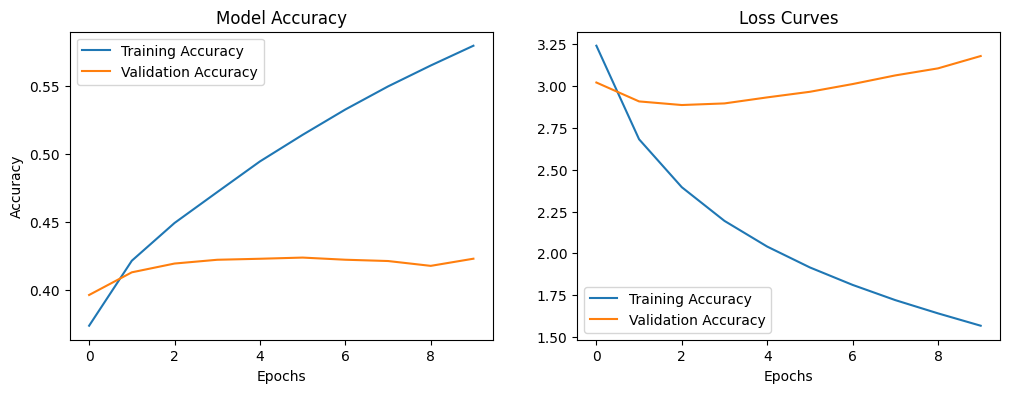

In [24]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Accuracy')
plt.plot(history.history['val_loss'], label='Validation Accuracy')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [25]:
# Display Final Accuracy
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")


Final Training Accuracy: 0.5797
Final Validation Accuracy: 0.4232


In [27]:
# Save the Model
model.save("image_caption_generator.keras")

Reloading Tuner from hyper_tuning/caption_classification/tuner0.json
Best Hyperparameters: {'num_layers': 4, 'activation': 'tanh', 'l2_reg': 0.5, 'batch_size': 64, 'units_0': 128, 'dropout': 0.1, 'units_1': 64, 'units_2': 64, 'optimizer': 'sgd', 'learning_rate': 0.0001, 'units_3': 96, 'units_4': 32}
Epoch 1/10
5379/5379 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.4999 - loss: 180.4331 - val_accuracy: 0.5021 - val_loss: 78.8401
Epoch 2/10
5379/5379 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.4995 - loss: 61.9854 - val_accuracy: 0.5039 - val_loss: 27.3418
Epoch 3/10
5379/5379 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.4993 - loss: 21.5942 - val_accuracy: 0.4999 - val_loss: 9.7806
Epoch 4/10
5379/5379 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.5001 - loss: 7.8205 - val_accuracy: 0.4999 - val_loss: 3.7920
Epoch 5/10
5379/5379 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.5003 - loss: 3.1236 - val_accuracy: 0.4999 - val_loss: 1.7499
Epoch 6/10
5379/5379 ━━━━━━━━━━━━━━━━━

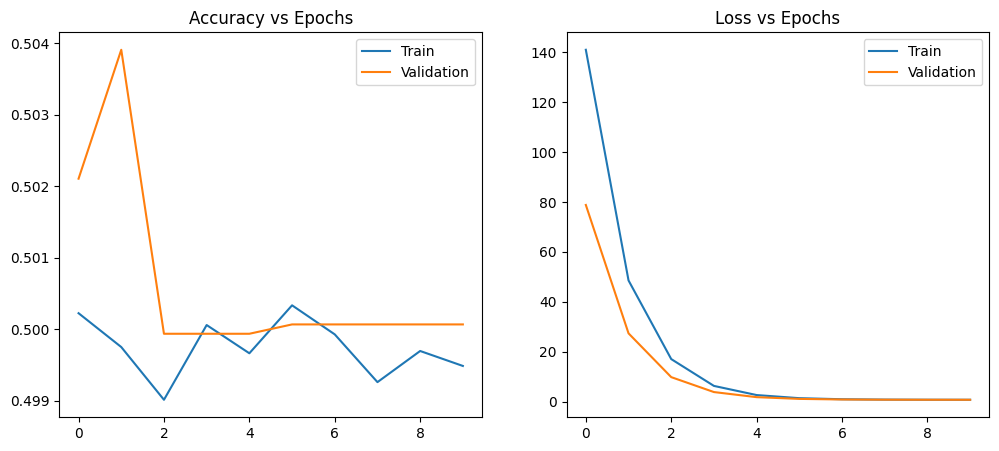

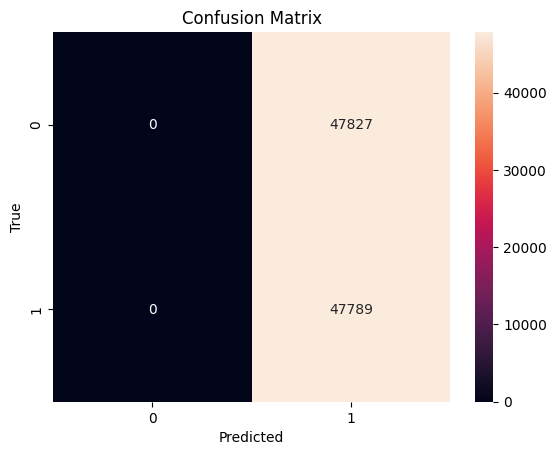

In [ ]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------------------------------
# 1. Prepare Classification Dataset (example)
# ----------------------------------------------------------------
Dogs = len(image_inputs)  # Replace image_inputs with your actual data
y = np.random.randint(0, 2, size=Dogs)  # Replace with real labels

X_train_full, X_test, y_train_full, y_test = train_test_split(
    image_inputs, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42)

# ----------------------------------------------------------------
# 2. Hyperparameter Tuning Model Builder
# ----------------------------------------------------------------
def model_builder(hp):
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=X_train.shape[1:]))

    num_layers = hp.Int('num_layers', 3, 5)
    activation = hp.Choice('activation', ['relu', 'sigmoid', 'tanh'])
    l2_reg = hp.Choice('l2_reg', [0.0, 0.0005, 0.5])
    hp.Choice('batch_size', [16, 32, 64])  # Tuned batch size

    for i in range(num_layers):
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', 32, 128, step=32),
            activation=activation,
            kernel_regularizer=regularizers.l2(l2_reg),
            kernel_initializer='random_normal'))

        model.add(layers.Dropout(hp.Float('dropout', 0.0, 0.5, step=0.1)))

    model.add(layers.Dense(2, activation='softmax'))

    optimizer = hp.Choice('optimizer', ['sgd', 'momentum', 'rmsprop', 'adam'])
    lr = hp.Choice('learning_rate', [1e-3, 1e-4])

    if optimizer == 'momentum':
        opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    else:
        optimizer_dict = {
            'sgd': tf.keras.optimizers.SGD,
            'rmsprop': tf.keras.optimizers.RMSprop,
            'adam': tf.keras.optimizers.Adam
        }
        opt = optimizer_dict[optimizer](learning_rate=lr)

    model.compile(
        optimizer=opt,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

    return model

# ----------------------------------------------------------------
# 3. Run Hyperparameter Search
# ----------------------------------------------------------------
tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=5,
    directory='hyper_tuning',
    project_name='caption_classification')

tuner.search(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    batch_size=32,  # Use fixed batch size during search
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)]
)

# ----------------------------------------------------------------
# 4. Retrieve Best Model
# ----------------------------------------------------------------
best_hps = tuner.get_best_hyperparameters()[0]
print(f"Best Hyperparameters: {best_hps.values}")

final_model = tuner.hypermodel.build(best_hps)
history = final_model.fit(
    X_train_full, y_train_full,
    epochs=10,
    batch_size=best_hps.get('batch_size'),
    validation_split=0.1)

# ----------------------------------------------------------------
# 5. Evaluation and Plots 
# ----------------------------------------------------------------
test_loss, test_acc = final_model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc:.4f}")

y_pred = final_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
conf_mat = tf.math.confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

plt.figure()
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


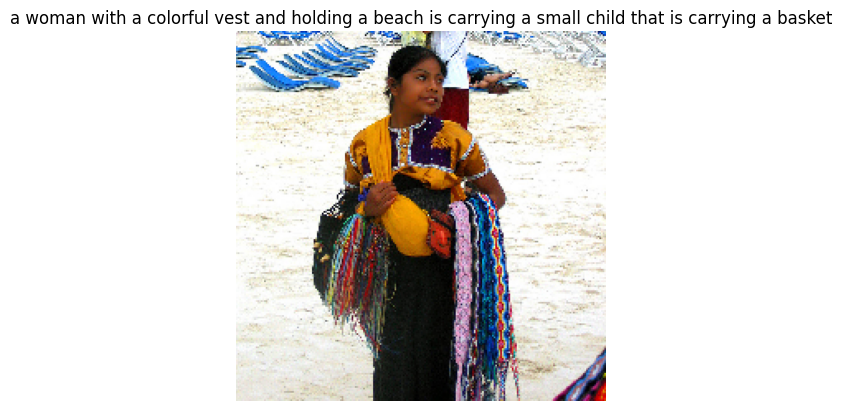

In [71]:
import random
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load base model without top layer
base_model = EfficientNetB0(
    weights='/kaggle/input/efficientnetb0-notop-h5/efficientnetb0_notop.h5',  # Using pre-trained weights from ImageNet
    include_top=False,
    pooling='avg'
)

# Correct image size for EfficientNetB0 is 224x224
def extract_features(image_path, base_model):
    img = load_img(image_path, target_size=(224, 224))  # Fixed to 224x224
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = base_model.predict(img_array, verbose=0)
    return features.flatten()

# Generate caption from image
def generate_caption(image_path, model, tokenizer, max_length):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Test image not found: {image_path}")
    
    feature = extract_features(image_path, base_model)
    caption = "startseq"
    
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([caption])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        y_pred = model.predict([feature.reshape(1, -1), sequence], verbose=0)
        word_index = np.argmax(y_pred)
        word = tokenizer.index_word.get(word_index, '')
        
        if word == "endseq" or word == '':
            break
            
        caption += ' ' + word
        
    return caption.replace('startseq', '').replace('endseq', '').strip()

# Example usage
test_image_name = random.choice(os.listdir(image_dir))
image_path = os.path.join(image_dir, test_image_name)
img = load_img(image_path, target_size=(224, 224))  # Match input size
plt.imshow(img)
plt.axis("off")
plt.title(generate_caption(image_path, model, tokenizer, max_length))
plt.show()
